# Conversational Chatbot Deep Learning
Semester: SoSe 2024

Name: Marco Menner

Matrikelnummer: 208778

## Requirements importieren
Im ersten Schritt werden alle Requirements in das Projekt geladen. Diese sollten bereits gemäß der Anleitung in der README-Datei im Virtual Environment installiert worden sein.

In [166]:
from __future__ import unicode_literals, print_function, division
from typing import Tuple, List
import pickle
import json
import random
import os
import re
import time
import math
import re
from datetime import datetime
from typing import List
import numpy as np
from matplotlib import pyplot as plt
from pathlib import Path
from datasets import load_dataset
import unicodedata
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from evaluate import load
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
from torch.nn.utils.rnn import pad_sequence
from torch.utils.tensorboard import SummaryWriter
import ipywidgets as widgets
from IPython.display import display

current_path = os.getcwd()

Im nächsten Schritt wird überprüft ob GPU oder TPU verfügbar ist. Der untere Button kann zum Wechsel zwischen GPU (Cuda) oder CPU verwendet werden. Empfohlen wird jedoch Cuda.

In [167]:
# Initialize the device variable
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Function to update device selection
def update_device(change):
    global device
    if change['new']:
        device = torch.device("cpu")
        device_button.description = "Use CUDA"
    else:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        device_button.description = "Use CPU"
    device_label.value = f"Selected Device: {device}"

# Create the button widget with custom styling
device_button = widgets.ToggleButton(
    value=(device.type == 'cpu'),
    description='Use CPU' if device.type == 'cuda' else 'Use CUDA',
    disabled=not torch.cuda.is_available(),  # Disable if CUDA is not available
    button_style='',  # Will apply custom style instead
    tooltip='Toggle between CPU and CUDA',
    layout=widgets.Layout(width='150px', height='40px')  # Set size of the button
)

# Apply custom CSS
device_button.style.button_color = 'blue'
device_button.style.font_weight = 'bold'
device_button.style.font_size = '16px'
device_button.style.font_color = 'white'

# Create a label to display the selected device
device_label = widgets.Label(value=f"Selected Device: {device}")

# Attach the update function to the button
device_button.observe(update_device, names='value')

# Display the button and label
display(device_button, device_label)

# Apply additional custom CSS
display(widgets.HTML("""
    <style>
        .widget-toggle-button {
            background-color: blue !important;
            color: white !important;
            font-weight: bold !important;
            font-size: 16px !important;
        }
    </style>
"""))


ToggleButton(value=False, description='Use CPU', layout=Layout(height='40px', width='150px'), style=ToggleButt…

Label(value='Selected Device: cuda')

HTML(value='\n    <style>\n        .widget-toggle-button {\n            background-color: blue !important;\n  …

## Daten Vorbereitung

Der erste Schritt besteht darin, die Tokens festzulegen, die dem Modell den Beginn und das Ende eines Satzes anzeigen. Zusätzlich werden kürzere Sätze auf die gleiche Länge gepaddet, indem Nullen hinzugefügt werden. Auf diesen Aspekt wird später noch näher eingegangen.

In [168]:
PAD_token = 0  # Padding
SOS_token = 1  # Start-of-sentence
EOS_token = 2  # End-of-sentence

Als nächsten Schritt wird die Vocab Klasse initialisiert. Diese Klasse beinhaltet folgende Funktionen:

* **Initialisierung:** Beim Erstellen eines Vocab Objekts werden drei spezielle
Tokens (PAD, SOS, EOS) initialisiert, die für Padding, Start und Ende eines Satzes stehen. Diese Tokens erhalten die ersten drei Indizes und die Anzahl der Wörter (num_of_words) wird auf 3 gesetzt. Kein anderes Wort wird folglich diese Tokens erhalten

* **add_sentence:** Diese Funktion nimmt einen Satz als String und fügt jedes Wort dieses Satzes zum Vokabular hinzu. Hierbei wird die Funktion *add_word* aufgerufen.

* **add_word:** Fügt ein einzelnes Wort zum Vokabular hinzu. Wenn das Wort noch nicht existiert, wird es mit einem neuen Index versehen und seine Häufigkeit auf 1 gesetzt. Existiert es bereits, wird nur die Häufigkeit erhöht.

* **trim:** Diese Funktion entfernt Wörter aus dem Vokabular, die weniger als *min_count* Mal vorkommen. Nach dem Trimmen bleiben nur Wörter im Vokabular, deren Häufigkeit größer oder gleich *min_count* ist. Die Wörterbücher werden danach neu initialisiert, um nur die häufigeren Wörter zu behalten. [source](https://www.kdnuggets.com/2019/11/create-vocabulary-nlp-tasks-python.html)

In [169]:
class Vocab:
    def __init__(self):
        self.trimmed = False
        self.word_to_index = {}
        self.word_to_count = {}
        self.index_to_word = {PAD_token: "PAD", SOS_token: "SOS", EOS_token: "EOS"}
        self.num_of_words = 3  # Count SOS, EOS, PAD

    def add_sentence(self, sentence: str):
        for word in sentence.split(' '):
            self._add_word(word)

    def _add_word(self, word: str):
        if word not in self.word_to_index:
            self.word_to_index[word] = self.num_of_words
            self.word_to_count[word] = 1
            self.index_to_word[self.num_of_words] = word
            self.num_of_words += 1
        else:
            self.word_to_count[word] += 1

    def trim(self, min_count: int):
        if self.trimmed:
            return
        self.trimmed = True

        keep_words = [word for word, count in self.word_to_count.items() if count >= min_count]

        # Reinitialize dictionaries
        self.word_to_index = {}
        self.word_to_count = {}
        self.index_to_word = {PAD_token: "PAD", SOS_token: "SOS", EOS_token: "EOS"}
        self.num_of_words = 3  # Count default tokens

        for word in keep_words:
            self._add_word(word)

Als nächster Schritt wird nun die *prepare_dataset* Funktion definiert. Dabei handelt es sich um die Hauptfunktion zur Vorbereitung des Datensatzes, mit dieser werden die Datensätze geladen und vorverarbeitet. Nach dem Ausführen der Funktion enthält die Rückgabe zum einen die gefüllte Vocab Klasse aber auch die vorbereiteten Train und Test Satzpaare die für das Training verwendet werden.

In [170]:
def prepare_dataset(max_length: int) -> Tuple[Vocab, List[List[str]], List[List[str]]]:
    print("Load conversations...")
    movie_conversations = load_pkl_data(os.path.join(current_path,"data/movie_conversations.pkl"))
    daily_conversations = load_huggingface_dataset()

    all_conversations = movie_conversations + daily_conversations
    print(f"Number of raw dialogs: {len(all_conversations)}")
    all_pairs = prepare_data(all_conversations)
    print(f"Number of prepared sentence pairs: {len(all_pairs)}")
    vocab = Vocab()

    all_pairs, vocab = filter_and_trim_data(vocab, all_pairs, max_length)
    print(f"Number of sentence pairs after filtering and trimming: {len(all_pairs)}")
    train_pairs, test_pairs = train_test_split(all_pairs, shuffle=True, test_size=0.3, random_state=42)

    return vocab, train_pairs, test_pairs

Das Ziel dieses Chatbots ist es, möglichst natürlich und menschenähnlich auf eine Vielzahl von allgemeinen Benutzerfragen zu antworten. Um dieses Ziel zu erreichen, wurden verschiedene Datensätze als Grundlage verwendet. Zum einen wurde ein Filmdatensatz genutzt, der von der Plattform [Convokit](https://convokit.cornell.edu/documentation/movie.html) heruntergeladen wurde. Dieser Filmdatensatz wurde zur besseren Handhabung in das Pkl-Dateiformat umgewandelt und anschließend importiert. Zum anderen kam der [Daily Dialog Datensatz](https://huggingface.co/datasets/li2017dailydialog/daily_dialog?row=5) von Huggingface zum Einsatz, der einfach in eine Liste umgewandelt werden kann, um die Implementierung zu erleichtern. Beide Datensätze tragen dazu bei, die Antworten des Chatbots möglichst natürlich und konversationsnah zu gestalten.

In [171]:
def load_pkl_data(pkl_file_path: str) -> List[List[str]]:
    with open(pkl_file_path, 'rb') as pkl_file:
        return pickle.load(pkl_file)


def load_huggingface_dataset() -> List[List[str]]:
    dataset = load_dataset("daily_dialog", "default", trust_remote_code=True)
    hf_dataset_train = dataset.data['train']['dialog'].to_pylist()
    hf_dataset_test = dataset.data['test']['dialog'].to_pylist()
    hf_dataset_validation = dataset.data['validation']['dialog'].to_pylist()

    return hf_dataset_train + hf_dataset_test + hf_dataset_validation

Folgendermaßen sehen dabei nun die Daten der Datensätze aus:

In [172]:
random.sample(load_pkl_data(os.path.join(current_path,"data/movie_conversations.pkl")), 2)
random.sample(load_huggingface_dataset(), 2)

[['I want to make a reservation under the name of William Smith . ',
  ' OK , Mr . Smith . When will you arrive ? ',
  ' Around 12:00 . ',
  ' Party of two ? ',
  ' No , we have five persons . ',
  ' All right , Mr . Smith . I will arrange a table for 5 at 12:00 for you . ',
  ' Thank you . '],
 ["Interesting lectures , aren't they ? ",
  ' Yes , very . I thought the last speaker was especially good . ',
  " Let me introduce myself , by the way . My name's Charies Ford . ",
  " How do you do ? I'm Bob Evans . "]]

Die Daten des Datensatzes bestehen aus Dialogen, die in Form von Listen von Sätzen dargestellt werden. Jeder Dialog enthält mehrere Sätze, die abwechselnd von verschiedenen Sprechern stammen und in einem Konversationsformat präsentiert werden. Es wird sichtbar das es sich derzeit noch um mehr als zwei Gesprächssätze handelt diese müssen im nachfolgenden weiter verarbeitet werden.

Für diese Verarbeitung wird nun die *prepare_data* Funktion verwendet in die beide Datensätze hineingeladen werden. Die Funktion iteriert über jede Konversation in der Liste conversations. Innerhalb jeder Konversation durchläuft sie die Sätze bis zum vorletzten Satz, daher wird range(len(conversation) - 1) verwendet. Für jeden Satz in der Konversation wird ein Paar gebildet, das aus dem aktuellen Satz conversation[i] und dem darauffolgenden Satz conversation[i + 1] besteht. Beide Sätze in diesem Paar werden durch die Funktion normalize_string normalisiert. Das normalisierte Paar wird anschließend zu einer neuen Liste hinzugefügt.

In [173]:
def prepare_data(conversations: List[List[str]]) -> List[List[str]]:
    return [[preprocess_string(conversation[i]), preprocess_string(conversation[i + 1])]
            for conversation in conversations for i in range(len(conversation) - 1)]

Die Funktion *preprocess_string* normalisiert eine Zeichenfolge, indem sie zunächst zu Kleinbuchstaben konvertiert und Leerzeichen entfernt. Anschließend wandelt sie die Zeichenfolge mit unicode_to_ascii in ASCII um und ersetzt alle nicht-alphabetischen Zeichen. Am Ende werden nochmals führende und nachfolgende Leerzeichen entfernt. Die Normalisierung der String sorgt für einheitliche und bereinigte Eingabedaten. Durch die Konvertierung zu Kleinbuchstaben, die Entfernung diakritischer Zeichen und unnötiger Symbole sowie die korrekte Handhabung von Satzzeichen wird das Vokabular reduziert und Rauschen eliminiert.

In [174]:
def preprocess_string(s: str) -> str:
    s = unicode_to_ascii(s.lower().strip())
    s = re.sub(r"[.!?]", "", s)  # Remove all punctuation marks
    s = re.sub(r"[^a-zA-Z]+", " ", s)  # Remove non-alphabetic characters
    return s.strip()

In [175]:
def unicode_to_ascii(s: str) -> str:
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

Hier ist ein Beispiel der Verwendung:

In [176]:
preprocess_string("Héllo, wörld! How's it going?")

'hello world how s it going'

Im nächsten Schritt der *prepare_dataset* Funktion werden die Daten nach dem Initialisieren der Vocab Klasse gefiltert und getrimmt.
* **filter_and_trim_data**:
Diese Funktion filtert zunächst die Paare, die zu lang sind, und fügt die Sätze dieser Paare der Vokab-Klasse hinzu. Anschließend werden selten vorkommende Wörter aus der Klasse entfernt, und die Paare, die diese Wörter enthalten, ebenfalls herausgefiltert. Zum Schluss gibt die Funktion die gefilterten Paare und das aktualisierte Vokabular zurück.

* **filter_pairs**:
Hier wird die Liste von Satzpaaren anhand der maximalen Länge gefiltert. Behalten werden nur Paare, bei denen beide Sätze kürzer als die angegebene maximale Länge sind.

* **trim_rare_words**:
Diese Funktion entfernt selten vorkommende Wörter aus dem Vokabular. Sie nimmt eine minimale Anzahl von Vorkommen als Parameter und behält nur die Wörter, die mindestens so oft vorkommen. Momentan ist dieser Score auf 3 gesetzt. Satzpaare, die Wörter enthalten, die nicht mehr im Vokabular sind, werden ebenfalls entfernt.

Das Reduzieren der Wörter ist ein wichtiger Schritt, um die Robustheit des Modells im späteren Training zu erhöhen. Wörter, die selten im Datensatz vorkommen, sollten nach Möglichkeit gar nicht verwendet werden, da sie das Modell unnötig komplex machen. Ebenso ist es relevant, die Sätze zu kürzen, um sicherzustellen, dass die Modelle, wie zum Beispiel LSTMs, optimal arbeiten können. Diese Architekturen haben eine begrenzte Kapazität für die Verarbeitung von Satzlängen, weshalb zu lange Sätze die Leistung und Effizienz des Modells beeinträchtigen können. Durch diese Maßnahmen wird die Verarbeitung vereinfacht und die Genauigkeit des Modells gesteigert.

In [177]:
def filter_and_trim_data(vocab: Vocab, pairs: List[List[str]], max_length: int) -> Tuple[List[List[str]], Vocab]:
    pairs = filter_pairs(pairs, max_length)
    for pair in pairs:
        vocab.add_sentence(pair[0])
        vocab.add_sentence(pair[1])
    pairs = trim_rare_words(vocab, pairs, min_count=3)
    return pairs, vocab

In [178]:
def filter_pairs(pairs: List[List[str]], max_length: int) -> List[List[str]]:
    return [pair for pair in pairs if len(pair[0].split()) < max_length and len(pair[1].split()) < max_length]

In [179]:
def trim_rare_words(vocab: Vocab, pairs: List[List[str]], min_count: int) -> List[List[str]]:
    vocab.trim(min_count)
    return [pair for pair in pairs
            if all(word in vocab.word_to_index for word in pair[0].split()) and
            all(word in vocab.word_to_index for word in pair[1].split())]

Da nun alle Funktionen zur Datenverarbeitung initialisiert sind kann diese ausgeführt werden. Die Funktion liefert nun die Vocab Klasse mit den Wörtern zurück und die Satzpaare in einem Train und Test Split von 70/30%. Die maximale Satzlänge wird auf 15 Wörter gesetzt. 

In [180]:
max_length = 10
vocab, train_pairs, test_pairs = prepare_dataset(max_length=max_length)
print()
print(f"Number of words: {vocab.num_of_words}")
print()
print(f"Number of train pairs: {len(train_pairs)}")
print(f"Number of test pairs: {len(test_pairs)}")
print()
print(f"Example of a the train pairs:\n{random.sample(train_pairs, 2)}")

Load conversations...
Number of raw dialogs: 96215
Number of prepared sentence pairs: 311477
Number of sentence pairs after filtering and trimming: 96626

Number of words: 11533

Number of train pairs: 67638
Number of test pairs: 28988

Example of a the train pairs:
[['oh yes yes', 'cool can i get one for vada'], ['what about driving to shanghai', 'driving no way it s too far']]


Anhand der obigen Ausgabe ist erst eine deutliche Vergrößerung des Datensatzes erkennbar und anschließend eine Verkleinerung durch die Filterung der Sätze. Hier durch wurde eine gute Grundlage geschaffen die Daten nun weiter für das Training vorzubereiten.

## Dataloader auffüllen

Der nächste Schritt ist nun die Daten in die DataLoader für das Training und Testen des Modells zu laden. Dataloader sind eine wichtige Komponente von PyTorch, da sie Daten effizient laden und in verarbeitbare Batches aufteilen. Dies erhöht die Parallelisierbarkeit und beschleunigt das Training.

Ein wichtige Funktion die hierfür verwendet wird ist die *convert_word_to_index* Funktion durch diese werden die Sätze mit hilfe des zuvor definierten Vocabs nun in Indizes umgewandelt, dazu folgendes Beispiel.

In [181]:
def convert_word_to_index(vocab: Vocab, sentence: str):
    return [vocab.word_to_index[word] for word in sentence.split(' ')]


convert_word_to_index(vocab=vocab, sentence="hello world how s it going")

[515, 966, 82, 31, 40, 111]

Diese *convert_word_to_index* Funktion wird in der nachfolgenden Funktion auf die Satzpaare angewandt. Zuvor wurden diese Elemente mit Nullen gefühlt um alle nicht definierten Stellen in der Länge zu padden. Das Ende des Satzes wird mit dem End-of-sentence Token versehen.

In [182]:
def process_pairs(pairs, vocab, max_length):
    num_pairs = len(pairs)
    input_sequences = np.zeros((num_pairs, max_length), dtype=np.int32)
    target_sequences = np.zeros((num_pairs, max_length), dtype=np.int32)

    for idx, (input_sentence, target_sentence) in enumerate(pairs):
        input_indices = convert_word_to_index(vocab, input_sentence)
        target_indices = convert_word_to_index(vocab, target_sentence)
        input_indices.append(EOS_token)
        target_indices.append(EOS_token)
        input_sequences[idx, :len(input_indices)] = input_indices
        target_sequences[idx, :len(target_indices)] = target_indices

    return input_sequences, target_sequences

Hier ist nochmals ein Beispiel wie die Satzpaare nach der Verwendung aussehen.

In [183]:
process_pairs([['hello world', 'how s it going']], vocab, max_length)

(array([[515, 966,   2,   0,   0,   0,   0,   0,   0,   0]]),
 array([[ 82,  31,  40, 111,   2,   0,   0,   0,   0,   0]]))

Die abgearbeiteten Satzpaar Sequenzen werden nun nach einer Umwandlung in Tensoren entsprechen der Batchsize in die Dataloader gefüllt. Dabei werden die Trainingsdaten nochmals geshuffelt.

In [184]:
def get_dataloader(vocab, batch_size, max_length, train_pairs, test_pairs):
    train_input_sequences, train_target_sequences = process_pairs(train_pairs, vocab, max_length)
    test_input_sequences, test_target_sequences = process_pairs(test_pairs, vocab, max_length)

    train_tensor_input = torch.LongTensor(train_input_sequences).to(device)
    train_tensor_target = torch.LongTensor(train_target_sequences).to(device)
    test_tensor_input = torch.LongTensor(test_input_sequences).to(device)
    test_tensor_target = torch.LongTensor(test_target_sequences).to(device)

    train_dataset = TensorDataset(train_tensor_input, train_tensor_target)
    test_dataset = TensorDataset(test_tensor_input, test_tensor_target)

    train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=batch_size)
    test_dataloader = DataLoader(test_dataset, sampler=SequentialSampler(test_dataset), batch_size=batch_size)

    return train_dataloader, test_dataloader

Nun kann die Funktion mit einer Batch Size von 512 ausgeführt werden.

In [185]:
batch_size = 256

train_dataloader, test_dataloader = get_dataloader(vocab=vocab, batch_size=batch_size, max_length=max_length,
                                                       train_pairs=train_pairs, test_pairs=test_pairs)

## Architektur

Als Architektur wurde sich für ein Sequence to Sequence Modell entschieden, dabei besteht diese aus einem Encoder, der die Eingabesequenz verarbeitet, und einem Decoder, der die Ausgabesequenz generiert. Des Weiteren wurde  der Encoder Architektur ein Bahdanau Attention Layer hinzugefügt um sich bei jedem Schritt auf verschiedene Teile der Eingabesequenz zu fokussieren zu können.

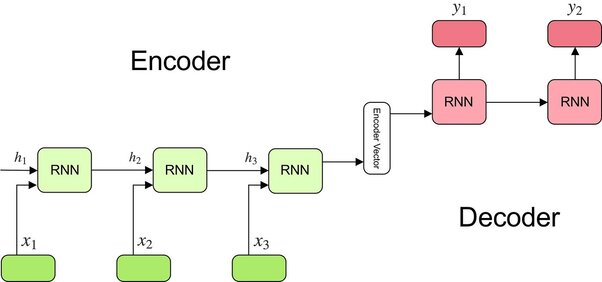

Darstellung einer Sequence to Sequence Architektur

### Encoder

Der Encoder besteht zum einen aus dem Embedding Layer der die eingegebenen Tokens in Vektoren umwandelt. Nach diesem folgt ein Dropout Layer der dazu dient Overfitting zu verhindern in dem während des Trainings zufällig einige der Verbindungen in den Neuronen entfernt werden. Drauffolgend werden die Daten im nächsten Layer an ein LSTM übergeben das standardmäßig eine Dropout Rate von 0.1 hat, wenn mehr als ein Layer für das LSTM definiert wird.

In [186]:
class EncoderLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1, dropout_p=0.1):
        super(EncoderLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers=num_layers, batch_first=True,
                            dropout=dropout_p if num_layers > 1 else 0)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input):
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.lstm(embedded)
        return output, hidden

### Decoder Architektur mit Bahdanau Attention

Im nächsten Schritt auf den Bahdanau Attention Mechatnismus eingegangen. Im weitesten Sinne wird in dieser Klasse wie folgt vorgegangen. Als erstes wird der Query Vektur um eine Dimension erweitert um die richtige Form zu haben. Nun wird im nächsten Schritt einmal der Query Layer und der der Key Layer auf die Query und den Key angewendet und dieser hier durch linear transformiert. Als Key wird der Encoder Output verwendet. Anhand dieser beiden Transformierten Vektoren wird nun der durch Addition und Anwendung der Tanh-Aktivierungsfunktion der Score berechnet. Dieser Score wird nun weiterhin wieder auf die korrekte Form gebracht. Im nächsten Schritt werden hieraus die Attention Gewichte berechnet mit der Zurhilfenahme der Softmax-Funktion. Der eigentliche Kontext Vektor wird nun anhand dieser Gewichte und Key-Vektoren im finalen Schritt berechnet. [Code Source](https://github.com/lukysummer/Bahdanau-Attention-in-Pytorch/blob/master/Attention.py) | [Source](https://medium.com/@a.akhterov/step-by-step-understanding-of-the-bahdanau-attention-mechanism-with-code-5c62e280ca13)

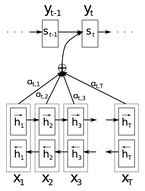

Bahdanau Attention

In [187]:
class BahdanauAttentionLayer(nn.Module):
    def __init__(self, hidden_size):
        super(BahdanauAttentionLayer, self).__init__()
        self.query_layer = nn.Linear(hidden_size, hidden_size)  # Wa
        self.key_layer = nn.Linear(hidden_size, hidden_size)  # Ua
        self.score_layer = nn.Linear(hidden_size, 1)  # Va

    def forward(self, query, keys):
        # Ensure query has shape (batch_size, 1, hidden_size)
        query = query.unsqueeze(1)  # Add time dimension

        # Apply linear transformations
        transformed_query = self.query_layer(query)  # Shape: (batch_size, 1, hidden_size)
        transformed_keys = self.key_layer(keys)  # Shape: (batch_size, seq_len, hidden_size)

        # Compute scores
        scores = self.score_layer(torch.tanh(transformed_query + transformed_keys))  # Shape: (batch_size, seq_len, 1)
        scores = scores.squeeze(2).unsqueeze(1)  # Shape: (batch_size, 1, seq_len)

        # Compute attention weights
        attention_weights = F.softmax(scores, dim=-1)  # Shape: (batch_size, 1, seq_len)

        # Compute context vector
        context_vector = torch.bmm(attention_weights, keys)  # Shape: (batch_size, 1, hidden_size)

        return context_vector, attention_weights

Im Decoder wird ebenfalls ein LSTM mit Dropout 0.1 bei mehr als einem Layer verwendet. Der wesentliche Unterschied ist, dass als Input size die doppelte hidden_size verwendet wird. Es wird damit begonnen, dass dem Forward Layer zu erst der Decoder Input Initial mit Start-of-Sentence Tokens gefüllt um den Start zu signalisieren, bzw. der Beginn einer neuen Sequenz. Darauf folgend werden die Hidden Layer des Decoders mit den selben Werten wie die des Encoders gefüllt. Dieser Schritt eine nahtlose Übergabe der gelernten Repräsentationen vom Encoder zum Decoder, was zu einer verbesserten Leistung und Effektivität der Encoder-Decoder-Architektur führt.

Im nächsten Schritt wird nun anhand der definierten maximal Länge über die Encoder Outputs iteriert um hieraus die Antwort auf die Eingabe zu generieren. Dazu wird die Funktion *forward_step* verwendet. Diese *forward_step* Funktion nutzt nun den Attention Mechanismus, der drauß erhaltene Kontext wird mit dem Embedding zusammengefügt und als Input des LSTMs verwendet. Der Output des LSTMs wird nun nochmals durch einen Linear Layer geleitet und zurück an die Forward Funktion gereicht.

Wenn nun während des Trainings ein Target Tensor definiert ist, wird im weiteren Teacher forcing, also das Vorgeben der Zielwerte während der Modellvorhersage, angewendet. Dies bedeutet, dass das Modell während des Trainings die tatsächlichen Zielwerte anstelle der vorhergesagten Werte als Eingabe für die nächsten Schritte verwendet, um den Lernprozess zu stabilisieren und zu beschleunigen.

Im finalen Schritt werden nun die Decoder Outputs zusammengefügt und eine Log-Softmax-Funktion auf den Tensor angewendet. Die Rückgabe enhält nun den Output, den Hidden State des Decoders und die Attention Weights. Wobei nur der Output für das weitere Training relevant ist.

In [188]:
class DecoderLSTMAttention(nn.Module):
    def __init__(self, hidden_size, output_size, max_length, num_layers=1, dropout=0.1):
        super(DecoderLSTMAttention, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attention = BahdanauAttentionLayer(hidden_size)
        self.lstm = nn.LSTM(2 * hidden_size, hidden_size, num_layers=num_layers, batch_first=True,
                            dropout=dropout if num_layers > 1 else 0)
        self.out = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout)
        self.max_length = max_length

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []
        attentions = []

        for i in range(self.max_length):
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            if target_tensor is not None:
                decoder_input = target_tensor[:, i].unsqueeze(1)  # Teacher forcing
            else:
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        attentions = torch.cat(attentions, dim=1)

        return decoder_outputs, decoder_hidden, attentions

    def forward_step(self, input, hidden, encoder_outputs):
        embedded = self.dropout(self.embedding(input))

        query = hidden[0][-1]  # Take the last layer's hidden state from (h_n, c_n)
        context, attn_weights = self.attention(query, encoder_outputs)
        input_lstm = torch.cat((embedded, context), dim=2)

        output, hidden = self.lstm(input_lstm, hidden)
        output = self.out(output)

        return output, hidden, attn_weights

Im folgenden werden nun der Encoder und der Decoder definiert und mit jeweils einer Hidden Size von 500 und einer Layer Anzahl von 2 definiert. Der Dropout wird auf 0.1 festgelegt.

In [189]:
hidden_size = 500
encoder_layer_number = 2
decoder_layer_number = 2
dropout = 0.1
encoder = EncoderLSTM(input_size=vocab.num_of_words, num_layers=encoder_layer_number, hidden_size=hidden_size).to(
    device)
decoder = DecoderLSTMAttention(hidden_size=hidden_size, output_size=vocab.num_of_words, num_layers=decoder_layer_number,
                                    max_length=max_length,
                                    dropout=dropout).to(device)

## Trainingsprozess

Für das Ausführen des Trainings wird jeweils eine Trainingsfunktion und eine Testfunktion benötigt die jeweils den Loss pro Epoche berechnet.

### Training pro Epoche

In der folgenden Funktion wird jeweils des Training für eine Epoche ausgeführt, dazu werden über die Daten des Train_dataloaders iteriert der die Trainingsdaten in Batches liefert. Hierbei werden zu Beginn jeweils input_tensor und target_tensor extrahiert. Vor jedem Vorwärtsdurchlauf werden die Gradienten der Optimierer (encoder_optimizer und decoder_optimizer) auf null gesetzt.

Die Eingabesequenz wird durch den Encoder geschickt, um encoder_outputs und encoder_hidden zu erhalten.

Der Decoder verwendet die encoder_outputs und encoder_hidden, zusammen mit der target_tensor, um die decoder_outputs (die Vorhersagen des Decoders) zu berechnen.

Die decoder_outputs und target_tensor werden genutzt, um den Verlust zu berechnen. Der Verlust wird mit der Verlustfunktion criterion (eine Negative Log Likelihood Loss) berechnet.

Um die Gradienten zu berechnen wird Backpropagation angewendet. Außerdem wird Gradienten-Clipping verwendet um zu verhindern das es zu einer Explosion dieser kommt. Als nächstes werden die Optimizer akualisiert und der Loss an die eigentliches Trainingsfunktion zurückgegeben.

In [190]:
def train_epoch(train_dataloader: DataLoader, encoder: EncoderLSTM, decoder: DecoderLSTMAttention, clip: float,
                encoder_optimizer: optim,
                decoder_optimizer: optim, criterion: nn.NLLLoss):
    total_loss = 0
    for data in train_dataloader:
        input_tensor, target_tensor = data

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_outputs, encoder_hidden = encoder(input_tensor)

        decoder_outputs, _, _ = decoder(encoder_outputs=encoder_outputs, encoder_hidden=encoder_hidden,
                                        target_tensor=target_tensor)

        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.view(-1)
        )
        loss.backward()

        # Gradient clipping
        nn.utils.clip_grad_norm_(encoder.parameters(), clip)
        nn.utils.clip_grad_norm_(decoder.parameters(), clip)

        encoder_optimizer.step()
        decoder_optimizer.step()

        total_loss += loss.item()

    return total_loss / len(train_dataloader)

### Test pro Epoche



Mit der *test_epoch* Funktion wird parallel zum Training evaluiert wie hoch der Loss angewendet auf den Testdatensatz performt. Dieser Schritt soll verhindern das es zu einem Overfitting auf die Trainingsdaten kommt.

Diese Funktion enthält ähnliche Elemente wie die Train Methode allerdings wird hier die Speicherung der Gradienten deaktivert da keine Modelparameter aktualisiert werden. Außerdem wird nur der Loss berechnet und zurück an die Hauptfunktion gegeben.

In [191]:
def test_epoch(test_dataloader: DataLoader, encoder: EncoderLSTM, decoder: DecoderLSTMAttention, criterion: nn.NLLLoss):
    total_loss = 0
    with torch.no_grad():
        for data in test_dataloader:
            input_tensor, target_tensor = data

            encoder_outputs, encoder_hidden = encoder(input_tensor)

            decoder_outputs, _, _ = decoder(encoder_outputs=encoder_outputs, encoder_hidden=encoder_hidden,
                                            target_tensor=target_tensor)

            loss = criterion(
                decoder_outputs.view(-1, decoder_outputs.size(-1)),
                target_tensor.view(-1)
            )
            total_loss += loss.item()

    return total_loss / len(test_dataloader)

Bei diesen beiden Funktionen handelt es sich um Hilfsfunktion um die während des Trainings die veraussichtlich noch verbleibende Zeit berechnen und anzeigen zu können.

In [192]:
def as_minutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def time_since(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (as_minutes(s), as_minutes(rs))

Mit dieser Funktion werden die wesentlichen States der Modellarchitektur gespeichert um später auch ohne Starten der Trainings ausgeführt werden zu können. In diesem Schritt wird jeweils auch die Vocab Klasse als Pkl-Datei mit abgelegt.

In [193]:
def save_checkpoint(epoch: int, encoder: EncoderLSTM, decoder: DecoderLSTMAttention, loss: float, vocab: Vocab,
                    path: str):
    checkpoint = {
        'epoch': epoch,
        'encoder_state_dict': encoder.state_dict(),
        'decoder_state_dict': decoder.state_dict(),
        'loss': loss,
    }
    torch.save(checkpoint, path)

    with open(Path(path).with_suffix('.pkl'), 'wb') as file:
        pickle.dump(vocab, file)

### Trainings Funktion

Hier handelt es sich um die eigentliche Trainingsfunktion. Zu Beginn wird die Loss-Funktion definiert. Für diese Architektur wurde NLLLoss (Negative Log Likelihood Loss) gewählt, die speziell für Textklassifizierung geeignet ist. Außerdem wird die Methode SummaryWriter von TensorBoard verwendet. Diese dient dazu, während des Trainings kontinuierlich den Trainings- und Test-Loss auszulesen und grafisch darzustellen. Der Vergleich der Trainingsperformance ist dabei sogar über mehrere Trainingsläufe möglich, da die Resultate einfach mit dem zum Trainingsstart eingelesenen Zeitstempel abgelesen werden können. Darüber hinaus zeigt diese Funktion, abgesehen von dem Aufrufen der *train_epoch* und *test_epoch*, an, wie sich der Loss verändert. Diese Methode ist so implementiert, dass eingestellt werden kann, wie oft diese Informationen angezeigt werden.

In [194]:
def train(train_dataloader: DataLoader, test_dataloader: DataLoader, vocab: Vocab, encoder: EncoderLSTM,
          decoder: DecoderLSTMAttention, encoder_optimizer: optim.Adam, decoder_optimizer: optim.Adam, clip: float,
          epochs: int,
          print_every=100):
    start = time.time()
    print_loss_total = 0

    criterion = nn.NLLLoss()

    # Define a timestamp for the logging directory
    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

    # Create a directory for the run logs
    log_dir = f'runs/{timestamp}_ep_{epochs}'
    checkpoint_dir = os.path.join(log_dir, 'checkpoints')
    os.makedirs(log_dir, exist_ok=True)
    os.makedirs(checkpoint_dir, exist_ok=True)

    # Initialize the SummaryWriter with the logging directory
    writer = SummaryWriter(log_dir=log_dir)

    for epoch in range(1, epochs + 1):
        loss = train_epoch(train_dataloader=train_dataloader, encoder=encoder, decoder=decoder,
                           encoder_optimizer=encoder_optimizer, decoder_optimizer=decoder_optimizer, clip=clip,
                           criterion=criterion)
        print_loss_total += loss

        # Log the training loss to TensorBoard
        writer.add_scalar('train/loss', loss, epoch)

        # Evaluate on the test set
        test_loss = test_epoch(test_dataloader=test_dataloader, encoder=encoder, decoder=decoder, criterion=criterion)

        # Log the test loss to TensorBoard
        writer.add_scalar('test/loss', test_loss, epoch)

        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) Train Loss: %.4f | Test Loss: %.4f' % (time_since(start, epoch / epochs),
                                                                       epoch, epoch / epochs * 100,
                                                                       print_loss_avg, test_loss))
            checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_epoch_{epoch}.pth')
            save_checkpoint(epoch, encoder, decoder, loss, vocab, path=checkpoint_path)

        # Close the TensorBoard writer
        writer.close()

Im Folgenden werden einige wichtige Hyperparameter des Modells näher beschrieben:

Die Learning Rate bestimmt, wie stark die Modellgewichte bei jeder Aktualisierung in Richtung des Gradienten der Verlustfunktion angepasst werden. Diese wurde möglichst niedrig gesetzt um eine zu schnelle Aktualisierung zu vermeiden.

Die Anzahl der Epochen gibt an, wie oft der gesamte Datensatz während des Trainings durchlaufen wird. Dieser Wert wurde durch experimentieren und Erfahrung definiert.

Der Clip-Wert begrenzt die Gradienten während des Trainings, um das Problem der Gradientenexplosion zu vermeiden und das Training zu stabilisieren.

Wichtige Parameter sind auch die Encoder- und Decoder-Optimierer, die hier mit dem Adam-Algorithmus eingestellt wurden.

**WICHTIG:** Das der Trainingsprozess sehr lange dauert und in einem externen Programm ausgeführt wurde, wurde hier nur bis zur ersten Epoche trainiert um zu veranschaulichen das der Trainingsprozess funktioniert!

In [195]:
learning_rate = 0.0001
epochs = 1
clip = 50.0

encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)

train(train_dataloader=train_dataloader, test_dataloader=test_dataloader, vocab=vocab,
      encoder_optimizer=encoder_optimizer, decoder_optimizer=decoder_optimizer, clip=clip, encoder=encoder,
      decoder=decoder, epochs=epochs, print_every=1)

0m 33s (- 0m 0s) (1 100%) Train Loss: 3.9172 | Test Loss: 3.1369


## Evaluierung

Nachdem das Training abgeschlossen ist, soll im nächsten Schritt das Ergebnis ausgewertet werden.

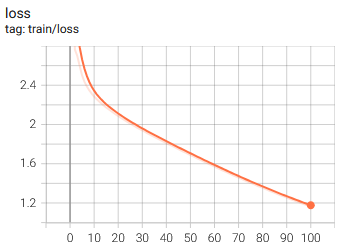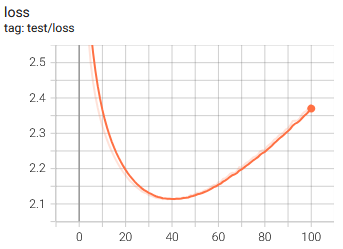

Für den Trainingsprozess wurden verschiedene Anzahlen von Layern und Größen getestet. Außerdem wurde die Maximal Länge der Sätze variiert. Insgesamt hat das Modell mit dem im Notebook hinterlegten Konfigurationen das bester Ergebnis erzielt. Anhand der obigen Grafik ist sehr deutlich sichtbar wann das Modell in in ein Overfitting Verhalten gerät. Da während des Trainings regelmäßig Checkpoints der Modellgewichte gemacht wurden kann nun einfach das Modell ab Epoche 40 für die Evaluierung verwendet werden.

Als nächster Schritt wird nun eine Evaluierung mit den Trainingsparametern auf einem weiteren Datensatz durchgeführt, der näher an der eigentlichen Aufgabe des Chatbots liegt. Dabei handelt es sich um eine Liste von 22 Alltagsfragen, die der Chatbot möglichst sinnvoll beantworten soll.

In [196]:
questions = [
    "What is your name?",
    "Where do you live?",
    "What color do you like the most?",
    "What do you do for a living?",
    "What are your hobbies?",
    "Do you have any pets?",
    "Which book do you find most interesting?",
    "Which movie do you like the best?",
    "What song do you love listening to?",
    "Where were you born?",
    "Which sport do you prefer playing or watching?",
    "What languages can you speak?",
    "Which season do you prefer?",
    "Which holiday do you look forward to?",
    "What do you like to drink?",
    "Which TV show do you watch regularly?",
    "What animal do you find fascinating?",
    "What was your best subject in school?",
    "What game do you like to play?",
    "What is your dream job?",
    "Are we friends?",
    "How are you?"
]

### Laden der Modell Parameter

Mit dieser Funktion werden nun die Encoder und Decoder States geladen.

In [197]:
def load_checkpoint(path: str, encoder: EncoderLSTM, decoder: DecoderLSTMAttention):
    if os.path.isfile(path):
        print(f"Loading checkpoint '{path}'")
        checkpoint = torch.load(path)
        epoch = checkpoint['epoch']
        encoder.load_state_dict(checkpoint['encoder_state_dict'])
        decoder.load_state_dict(checkpoint['decoder_state_dict'])
        print(f"Loaded checkpoint '{path}' (epoch {epoch})")
        return encoder, decoder
    else:
        print(f"No checkpoint found at '{path}'")
        return None, None

Nach dem Laden der Encoder- und Decoder-Zustände können der Encoder und Decoder auf Evaluierung gestellt werden, was den Modus verändert. Dadurch werden die zuvor notwendigen Dropout-Mechanismen deaktiviert. Wichtig beim Laden der Zustände ist, dass zuvor bereits die leeren Architekturen initialisiert wurden.

In [198]:
encoder, decoder = load_checkpoint(
    path=os.path.join(current_path,f"model_checkpoint/model.pth"),
    encoder=encoder, decoder=decoder)

encoder.eval()

Loading checkpoint 'C:\Users\Marco\dev\git\chatbot_notebook\model_checkpoint/model.pth'
Loaded checkpoint 'C:\Users\Marco\dev\git\chatbot_notebook\model_checkpoint/model.pth' (epoch 40)


EncoderLSTM(
  (embedding): Embedding(11533, 500)
  (lstm): LSTM(500, 500, num_layers=2, batch_first=True, dropout=0.1)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [199]:
decoder.eval()

DecoderLSTMAttention(
  (embedding): Embedding(11533, 500)
  (attention): BahdanauAttentionLayer(
    (query_layer): Linear(in_features=500, out_features=500, bias=True)
    (key_layer): Linear(in_features=500, out_features=500, bias=True)
    (score_layer): Linear(in_features=500, out_features=1, bias=True)
  )
  (lstm): LSTM(1000, 500, num_layers=2, batch_first=True, dropout=0.1)
  (out): Linear(in_features=500, out_features=11533, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

Oben dargestellt ist nun nochmal die exakte Darstellung beider Modell mit den jeweiligen Layern.

Im Folgenden wird der Inferenzschritt beschrieben.
Die Funktion tensor_from_sentence wandelt einen Satz mithilfe des Vocabs in eine Liste von Indizes um, fügt ein End-Token hinzu und konvertiert diese Liste in einen Tensor. Dieser Tensor wird anschließend von der Inferenzfunktion genutzt, um den Satz durch das Encoder-Decoder-Modell zu schicken. Der Decoder generiert daraufhin eine Sequenz von Indizes, die bis zum Erreichen des End-Tokens in Wörter umgewandelt werden. Schließlich werden die dekodierten Wörter und die Attention Weights des Decoders zurückgegeben.

In [200]:
def tensor_from_sentence(vocab: Vocab, sentence: str):
    indexes = convert_word_to_index(vocab, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(1, -1)


def inference(encoder: EncoderLSTM, decoder: DecoderLSTMAttention, sentence: str, vocab: Vocab):
    with torch.no_grad():
        input_tensor = tensor_from_sentence(vocab, sentence)

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, decoder_hidden, decoder_attn = decoder(encoder_outputs, encoder_hidden)

        _, topi = decoder_outputs.topk(1)
        decoded_ids = topi.squeeze()

        decoded_words = []
        for idx in decoded_ids:
            decoded_words.append(vocab.index_to_word[idx.item()])
    return decoded_words, decoder_attn

### Evaluierung mit Perplexity Score

Zur weiteren Evaluierung wird der Perplexity Score verwendet. Dieser Score ist ein Maß für die Qualität von Sprachmodellen. Es bewertet, wie gut ein Sprachmodell Wahrscheinlichkeiten für eine Sequenz von Wörtern vorhersagen kann. Ein niedrigerer Perplexity Score zeigt an, dass das Modell besser darin ist, die Wahrscheinlichkeit der Wörter in einem Text vorherzusagen. Dafür wurde das Modul von Huggingface verwendet, in diesem ist das Modell GPT-2 als Bewertung Instanz geschalten.

In [201]:
def dataset_input(encoder: EncoderLSTM, decoder: DecoderLSTMAttention, vocab: Vocab):
    # ANSI escape codes for colors and bold text
    yellow_bold = "\033[1;33m"
    green = "\033[0;32m"
    red = "\033[0;31m"
    cyan = "\033[0;36m"
    reset = "\033[0m"

    perplexity = load("perplexity", module_type="metric")

    perplexities = []

    # Evaluating each question
    for question in questions:
        try:
            # Normalize question
            normalized_question = preprocess_string(question)
            # Evaluate question
            output_words, _ = inference(encoder, decoder, normalized_question, vocab)
            # Format and print response sentence
            output_words = [x for x in output_words if not (x == 'EOS' or x == 'PAD')]
            output_sentence = ' '.join(output_words)
            print(f"{yellow_bold}Question:{reset} {cyan}{question}{reset}")
            print(f"{green}Answer:{reset} {output_sentence}")
            results = perplexity.compute(model_id='gpt2',
                                         add_start_token=True,
                                         predictions=[output_sentence])
            print(f"{green}Perplexity score:{reset} {results['mean_perplexity']}")
            perplexities.append(results['mean_perplexity'])
            print()

        except KeyError:
            print(
                f"{red}Some of the input words in the question are unknown, please formulate the sentence differently.{reset}")

    print(f"{yellow_bold}Overall perplexity score:{reset} {np.mean(perplexities)}")

dataset_input(encoder=encoder, decoder=decoder, vocab=vocab)

Question: What is your name?
Answer: me


  0%|          | 0/1 [00:00<?, ?it/s]

Perplexity score: 6384.91259765625

Question: Where do you live?
Answer: herenear the supermarket increases


  0%|          | 0/1 [00:00<?, ?it/s]

Perplexity score: 16264.3916015625

Question: What color do you like the most?
Answer: it s very much


  0%|          | 0/1 [00:00<?, ?it/s]

Perplexity score: 574.9309692382812

Question: What do you do for a living?
Answer: i m a good


  0%|          | 0/1 [00:00<?, ?it/s]

Perplexity score: 200.8462677001953

Question: What are your hobbies?
Answer: suzhou my daughter i was here


  0%|          | 0/1 [00:00<?, ?it/s]

Perplexity score: 1008.3782348632812

Question: Do you have any pets?
Answer: yes


  0%|          | 0/1 [00:00<?, ?it/s]

Perplexity score: 30530.626953125

Question: Which book do you find most interesting?
Answer: i like the food in the food


  0%|          | 0/1 [00:00<?, ?it/s]

Perplexity score: 82.51496124267578

Question: Which movie do you like the best?
Answer: i like the food in the food


  0%|          | 0/1 [00:00<?, ?it/s]

Perplexity score: 82.51496124267578

Question: What song do you love listening to?
Answer: you like to love me


  0%|          | 0/1 [00:00<?, ?it/s]

Perplexity score: 184.6300811767578

Question: Where were you born?
Answer: i was in the bathroom


  0%|          | 0/1 [00:00<?, ?it/s]

Perplexity score: 56.81135940551758

Question: Which sport do you prefer playing or watching?
Answer: i like orange and a sprite


  0%|          | 0/1 [00:00<?, ?it/s]

Perplexity score: 994.6595458984375

Question: What languages can you speak?
Answer: i m a manager


  0%|          | 0/1 [00:00<?, ?it/s]

Perplexity score: 412.1962890625

Question: Which season do you prefer?
Answer: orange the deposit deposit


  0%|          | 0/1 [00:00<?, ?it/s]

Perplexity score: 8746.353515625

Question: Which holiday do you look forward to?
Answer: i like the food of my family


  0%|          | 0/1 [00:00<?, ?it/s]

Perplexity score: 104.41029357910156

Question: What do you like to drink?
Answer: i want to get some money


  0%|          | 0/1 [00:00<?, ?it/s]

Perplexity score: 46.745731353759766

Question: Which TV show do you watch regularly?
Answer: i have the idea


  0%|          | 0/1 [00:00<?, ?it/s]

Perplexity score: 131.03631591796875

Question: What animal do you find fascinating?
Answer: he s a very emotional girl


  0%|          | 0/1 [00:00<?, ?it/s]

Perplexity score: 509.94091796875

Question: What was your best subject in school?
Answer: i was in the room yesterday


  0%|          | 0/1 [00:00<?, ?it/s]

Perplexity score: 85.7713394165039

Question: What game do you like to play?
Answer: i like to look at a chicken


  0%|          | 0/1 [00:00<?, ?it/s]

Perplexity score: 87.26315307617188

Question: What is your dream job?
Answer: i have a headache


  0%|          | 0/1 [00:00<?, ?it/s]

Perplexity score: 166.1956024169922

Question: Are we friends?
Answer: are you going to eat


  0%|          | 0/1 [00:00<?, ?it/s]

Perplexity score: 85.14027404785156

Question: How are you?
Answer: fine thank you


  0%|          | 0/1 [00:00<?, ?it/s]

Perplexity score: 2847.26708984375

Overall perplexity score: 3163.0699116099963


Anhand der Evaluierung fällt folgendes auf:

Der Chatbot kann einfache Fragen gut und direkt beantworten. Beispielsweise gibt er auf "What is your name?" die Antwort "me" und auf "Do you have any pets?" antwortet er mit "yes". Dies zeigt, dass der Bot grundlegende Fragen korrekt erkennt und prägnante Antworten liefern kann. Außerdem ist die Geschwindigkeit, mit der der Chatbot die Antworten generiert (zwischen 8 und 66.67 it/s), beeindruckend und zeigt die Effizienz des Bots in der Antwortgenerierung. Bei der Frage "What do you do for a living?" antwortet der Bot mit "i m a good", was zumindest teilweise den Kontext der Frage widerspiegelt. Auch bei "How are you?" antwortet der Bot passend mit "fine thank you". Einige der Antworten, wie zum Beispiel "What color do you like the most?" mit einem Perplexity Score von 574.93 und "Which book do you find most interesting?" mit 82.51, zeigen, dass der Chatbot in einigen Fällen weniger Unsicherheit in seinen Antworten hat und potenziell bessere Vorhersagen trifft.

Verbesserungspotential besteht insbesondere darin das kontextuelle Verständnis des Chatbots weiter zu verbessern, um relevantere und genauere Antworten auf komplexere Fragen zu geben. Insgesamt sollte der Perplexity Score weiter reduziert werden um die Qualität und Konsistenz der Antworten zu erhöhen. 


### Evaluierung mit Attention Matrix

In Sequenzmodellen wie RNNs oder LSTMs hat jeder Zustand (z.B. ein Wort in einem Satz) nur begrenzte Sicht auf den Rest der Sequenz. Eine Attention Matrix erlaubt es dem Modell, eine globale Sicht auf die gesamte Sequenz zu haben und dynamisch zu entscheiden, welche Teile der Eingabe zu einem bestimmten Zeitpunkt wichtig sind. Hierbei wird angezeigt wie viel Aufmerksamkeit welchem Wort des Satzes beigemessen wird. Dabei werden nun zuvor die PAD und EOS Tokens des Antwort Satzes entfernt und mit Hilfe der Attention Weights dargestellt.

In [202]:
def visualize_attention_weights(input_sentence, words, attention_weights):

    # Move attention weights to CPU and convert to numpy
    attention_weights_cpu = attention_weights.cpu().detach().numpy()

    # Filter out 'PAD' and 'EOS' tokens from the response and get their indices
    filtered_response_tokens = []
    filtered_indices = []

    for idx, token in enumerate(words):
        if token not in ['PAD', 'EOS']:
            filtered_response_tokens.append(token)
            filtered_indices.append(idx)

    # Filter the attention weights to exclude 'PAD' and 'EOS' tokens in both rows and columns
    filtered_attention_weights = attention_weights_cpu[0, filtered_indices, :]
    filtered_attention_weights = filtered_attention_weights[:, filtered_indices]

    plot_attention_weights(input_sentence, filtered_response_tokens, filtered_attention_weights)


def plot_attention_weights(input_sentence, response_tokens, attention_weights):
    fig, ax = plt.subplots()
    cax = ax.matshow(attention_weights, cmap='viridis')

    ax.set_xticklabels([''] + input_sentence.split(), rotation=90)
    ax.set_yticklabels([''] + response_tokens)

    plt.title('Bahdanau Attention Weights')
    plt.colorbar(cax)
    plt.show()

C:\Users\Marco\AppData\Local\Temp\ipykernel_13056\1760487052.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + input_sentence.split(), rotation=90)
C:\Users\Marco\AppData\Local\Temp\ipykernel_13056\1760487052.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + response_tokens)


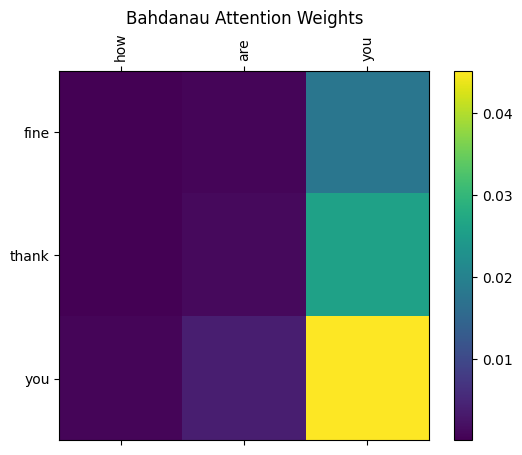

In [203]:
input_sentence = "how are you"

words, attention_weights = inference(encoder, decoder, input_sentence, vocab)

visualize_attention_weights(input_sentence, words, attention_weights)

Das Modell zeigt eine klare Attention auf das Wort "you" sowohl in der Eingabe als auch in der Ausgabe. Dies ist sinnvoll, da "you" in beiden Sätzen vorkommt und das Modell somit dieses Wort als besonders relevant erkennt. Die anderen Wörter erhalten eine eher gleichmäßige Aufmerksamkeit, was darauf hindeutet, dass das Modell sie als weniger entscheidend für die Erzeugung der Ausgabewörter betrachtet.

## Nutzer Eingabe

Mit der folgenden Funktion wird eine Eingabe über die Konsole geschaffen, durch die der Nutzer interaktiv mit dem Modell Konversationen führen kann. Dabei wird eine format_sentence-Funktion eingeführt, die den vom Modell zurückgegebenen Satz in ein sauberes Format bringt.

In [204]:
def format_sentence(sentence):
    if not sentence:
        return sentence
    sentence = sentence.strip()

    # Dictionary of contractions to replace
    contractions = {
        r'\b s \b': " is ",
        r'\b re \b': " are ",
    }

    # Perform the substitutions
    for pattern, replacement in contractions.items():
        sentence = re.sub(pattern, replacement, sentence)

    if not sentence.endswith('.'):
        sentence += '.'

    return sentence[0].upper() + sentence[1:]

Hier wird gezeigt, wie der Satz umgewandelt wird: Der Satzbeginn wird groß geschrieben, Abkürzungen von 'is' und 'are' werden ausgeschrieben und am Ende des Satzes wird ein Punkt eingefügt.

In [205]:
sentence = 'hello world how s it going'
formated_sentence = format_sentence(sentence)

print(sentence)
print(formated_sentence)

hello world how s it going
Hello world how is it going.


Das Programm befindet sich in einer Schleife, in der es kontinuierlich Benutzereingaben abfragt. Der Benutzer wird aufgefordert, einen Satz einzugeben. Wenn der Benutzer 'q' oder 'quit' eingibt, wird das Programm beendet. Der eingegebene Satz wird durch *preprocess_string* (input_sentence) normalisiert. Der normalisierte Satz wird durch das Modell (Encoder und Decoder) verarbeitet, um eine Antwort zu generieren. Die generierten Wörter werden zu einem Satz zusammengefügt, wobei das End-of-Sentence-Token (EOS) und die Paddings (PAD) entfernt wird. Die Antwort wird formatiert und ausgegeben. Falls ein unbekanntes Wort in der Eingabe gefunden wird, gibt das Programm eine Fehlermeldung aus.

In [206]:
import ipywidgets as widgets
from IPython.display import display, clear_output

# Create input and output widgets
input_box = widgets.Text(placeholder='Type your question here...')
output_box = widgets.Output()

def on_submit(change, encoder, decoder, vocab):
    with output_box:
        clear_output()
        input_sentence = change['new']
        if input_sentence.lower() in ['q', 'quit']:
            display(widgets.HTML("<b style='color: yellow;'>Goodbye! Have a great day!</b>"))
            input_box.close()
            return
        try:
            # Normalize sentence
            input_sentence = preprocess_string(input_sentence)
            # Evaluate sentence
            output_words, _ = inference(encoder, decoder, input_sentence, vocab)
            # Format and print response sentence
            output_words = [x for x in output_words if not (x == 'EOS' or x == 'PAD')]
            formatted_response = format_sentence(' '.join(output_words))
            display(widgets.HTML(f"<span style='color: green;'>Answer:</span> {formatted_response}"))
        except KeyError:
            display(widgets.HTML("<span style='color: red;'>Some of the input you used is unknown, please formulate the sentence differently.</span>"))

def user_input(encoder, decoder, vocab):
    # Greeting message
    display(widgets.HTML("<b>Hello! How can I assist you today?</b>"))

    # Link the input box to the callback function
    input_box.observe(lambda change: on_submit(change, encoder, decoder, vocab), names='value')

    # Display the input and output widgets
    display(input_box)
    display(output_box)
    
user_input(encoder=encoder, decoder=decoder, vocab=vocab)

HTML(value='<b>Hello! How can I assist you today?</b>')

Text(value='', placeholder='Type your question here...')

Output()

## Fazit

Insgesamt zeigt der Chatbot ein teilweises Verständnis der Eingaben und antwortet gelegentlich korrekt. Allerdings ist dies zu selten der Fall. Ein Grund hierfür könnte sein, dass der Chatbot mit zu wenig spezifischen Daten trainiert wurde. Um das Problem der allgemeinen Konversation zu lösen, wären wohl mehr und vielfältigere Daten erforderlich, um bessere Ergebnisse zu erzielen. 

Abgesehen davon wird deutlich, dass Seq2Seq-Modell mit Bahdanau-Attention von Natur aus begrenzt sind, insbesondere im Vergleich zu fortschrittlicheren Modellen wie ChatGPT. Moderne Modelle wie ChatGPT haben Zugang zu extrem großen Datensätzen und nutzen fortschrittliche Architekturen wie Transformer mit Multi-Head Attention, die eine deutlich bessere Leistung bei der Kontextverarbeitung und Generierung natürlicher Sprache ermöglichen. Diese Unterschiede in der Datenmenge und der Modellarchitektur tragen wesentlich dazu bei, dass Modelle wie ChatGPT eine überlegene Performance zeigen. 

Vermutlich könnte die Nutzung vortrainierter Sprachmodelle wie GPT oder BERT als Ausgangspunkt und anschließendes Fein-Tuning auf einem spezifischen Datensatz die Leistungsfähigkeit des Chatbots erheblich verbessern. Diese Modelle verfügen über viel größere und diversere Trainingsdatensätze, was ihnen ein tieferes Sprachverständnis und eine bessere Kontextverarbeitung ermöglicht.

Nichtsdestotrotz war dieses Projekt eine gute Möglichkeit, zu sehen, wie anspruchsvoll die Entwicklung eines leistungsfähigen Chatbots wirklich ist. Es zeigte die Komplexität, die mit der Erstellung eines Systems verbunden ist, das nicht nur grammatikalisch korrekt, sondern auch semantisch präzise und kontextuell relevante Antworten liefern kann. Zudem bot es wertvolle Einblicke in die Herausforderungen und Limitierungen, die bei der Implementierung und dem Training von Seq2Seq-Modellen mit Bahdanau-Attention auftreten.